# Market Price Driven Model

## Overview

The purpose of this experiment is to tune and test the PI controller, by driving the market price directly.

## Shared setup and dependencies

In [1]:
from shared import *

In [2]:
%pip show cadCAD

Name: cadCAD
Version: 0.4.23
Summary: cadCAD: a differential games based simulation software package for research, validation, and         Computer Aided Design of economic systems
Home-page: https://github.com/cadCAD-org/cadCAD
Author: Joshua E. Jodesty
Author-email: joshua@block.science
License: LICENSE.txt
Location: /Users/bscholtz/workspace/reflexer/venv/lib/python3.8/site-packages
Requires: funcy, pandas, fn, pathos
Required-by: 
Note: you may need to restart the kernel to use updated packages.


# Parameters

These are the key model parameters:
* `options.MarketPriceSource == options.MarketPriceSource.EXTERNAL`, with a step input sweep set as the market price external data source.

In [3]:
market_price_data = [
    step_dataframe(50, 0.01, time_period=86400),
    step_dataframe(50, 0.05, time_period=86400),
    step_dataframe(50, 0.1, time_period=86400)
]
market_price_data[0].iloc[50]

seconds_passed    86400.00
price_move            0.01
Name: 50, dtype: float64

* PI controller constant sweep

In [4]:
kp_sweep = [-6.944e-06]
ki_sweep = [-60.0/(24*3600)]

In [5]:
# kp = [-6.944e-06]
# ki = [-60.0/(24*3600)]

# controller_sweep = list(itertools.product(kp, ki))
# controller_sweep

# kp_sweep = [x[0] for x in controller_sweep]
# ki_sweep = [x[1] for x in controller_sweep]

* Error term calculation

In [6]:
error_term = [
    lambda target, measured: target - measured,
    #lambda target, measured: (target - measured) / measured,
    #lambda target, measured: (target - measured) / target
]

* Integral type

In [7]:
integral_type = [options.IntegralType.LEAKY.value]

## Simulation Configuration

Set the simulation timesteps to the minimum dataset length:

In [8]:
minimum_timesteps = min([df.shape[0] for df in market_price_data])
SIMULATION_TIMESTEPS = range(minimum_timesteps)
SIMULATION_TIMESTEPS

range(0, 720)

Override certain parameter sweeps with the generated sets, using ConfigWrapper for convenience:

In [9]:
# Update parameter options
update_params = {
    # By using an Enum, we can self-document all possible options
    options.MarketPriceSource.__name__: [options.MarketPriceSource.EXTERNAL.value],
    options.DebtPriceSource.__name__: [options.DebtPriceSource.DISABLED.value],
    options.IntegralType.__name__: integral_type,
    'controller_enabled': [True],
    # Generate a lambda for each test dataframe, that returns a row value at a specific timestep
    'seconds_passed': [
        lambda timestep, df=df.copy(): int(df.iloc[timestep - 1]['seconds_passed'])
        for df in market_price_data
    ],
    'price_move': [
        lambda timestep, df=df.copy(): float(df.iloc[timestep - 1]['price_move'])
        for df in market_price_data
    ],
    'kp': kp_sweep,
    'ki': ki_sweep,
    # Select or sweep the error term calculation, as a lambda
    # e.g. p*-p vs (p*-p)/p vs (p*-p)/p*
    'error_term': error_term,
}

'''
The ConfigWrapper allows you to pass a model as an argument, and update the simulation configuration.
Maps (params, states) would be merge updated, and all other options are overrides.
'''
system_simulation = ConfigWrapper(system_model, M=update_params, N=1, T=SIMULATION_TIMESTEPS)

## Simulation Execution

In [10]:
del configs[:]

system_simulation.append()

(data, tensor_field, sessions) = run(drop_midsteps=True)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (720, 23, 3, 15)
Execution Method: local_simulations
SimIDs   : [0, 0, 0]
SubsetIDs: [0, 1, 2]
Ns       : [0, 1, 2]
ExpIDs   : [0, 0, 0]
Execution Mode: parallelized
Total execution time: 1.42s


## Data Analysis

In [11]:
df = data.copy()
df

,index,error_star,error_hat,old_error_star,old_error_hat,error_star_integral,error_hat_integral,error_star_derivative,error_hat_derivative,target_rate,...,market_price,debt_price,timedelta,timestamp,blockheight,simulation,subset,run,substep,timestep
0,0,0.000000e+00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.000000e+00,...,1.0,1.0,0,2018-12-18 00:00:00,0,0,0,1,0,0
1,6,0.000000e+00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,-0.000000e+00,...,1.0,1.0,6380,2018-12-18 01:46:20,425,0,0,1,6,1
2,12,0.000000e+00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,-0.000000e+00,...,1.0,1.0,3739,2018-12-18 02:48:39,674,0,0,1,6,2
3,18,0.000000e+00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,-0.000000e+00,...,1.0,1.0,5510,2018-12-18 04:20:29,1041,0,0,1,6,3
4,24,0.000000e+00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,-0.000000e+00,...,1.0,1.0,3923,2018-12-18 05:25:52,1302,0,0,1,6,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2158,12938,-1.510503e-11,-0.1,0.0,0.0,0.0,-322182.55,0.0,0.0,1.048893e-16,...,1.1,1.0,7243,2019-01-27 01:45:50,230491,0,2,2,6,716
2159,12944,-1.510503e-11,-0.1,0.0,0.0,0.0,-322558.75,0.0,0.0,1.048893e-16,...,1.1,1.0,3762,2019-01-27 02:48:32,230741,0,2,2,6,717
2160,12950,-1.510503e-11,-0.1,0.0,0.0,0.0,-322959.25,0.0,0.0,1.048893e-16,...,1.1,1.0,4005,2019-01-27 03:55:17,231008,0,2,2,6,718
2161,12956,-1.510503e-11,-0.1,0.0,0.0,0.0,-323448.15,0.0,0.0,1.048893e-16,...,1.1,1.0,4889,2019-01-27 05:16:46,231333,0,2,2,6,719


In [12]:
df['target_rate_hourly'] = df.target_rate # * 3600
df['error_star_derivative_scaled'] = df.error_star_derivative * 3600
df['error_hat_derivative_scaled'] = df.error_star_derivative * 3600

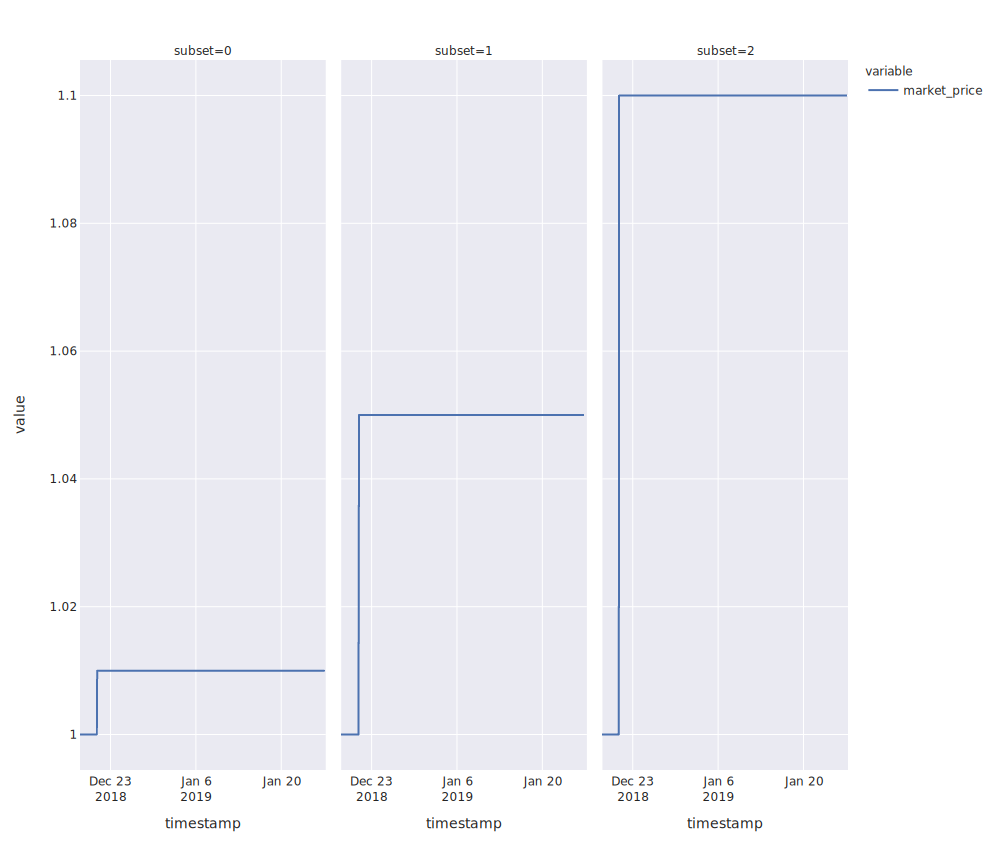

In [13]:
fig = px.line(
    df,
    x='timestamp',
    y=['market_price'],
    facet_col='subset',
    facet_col_wrap=3,
    template='seaborn',
    height=800
)

# fig.show()
fig.write_image('plots/notebook_validation_market_price/market_price.svg', width=1000, height=850)
from IPython.display import SVG,display
display(SVG(filename='plots/notebook_validation_market_price/market_price.svg'))

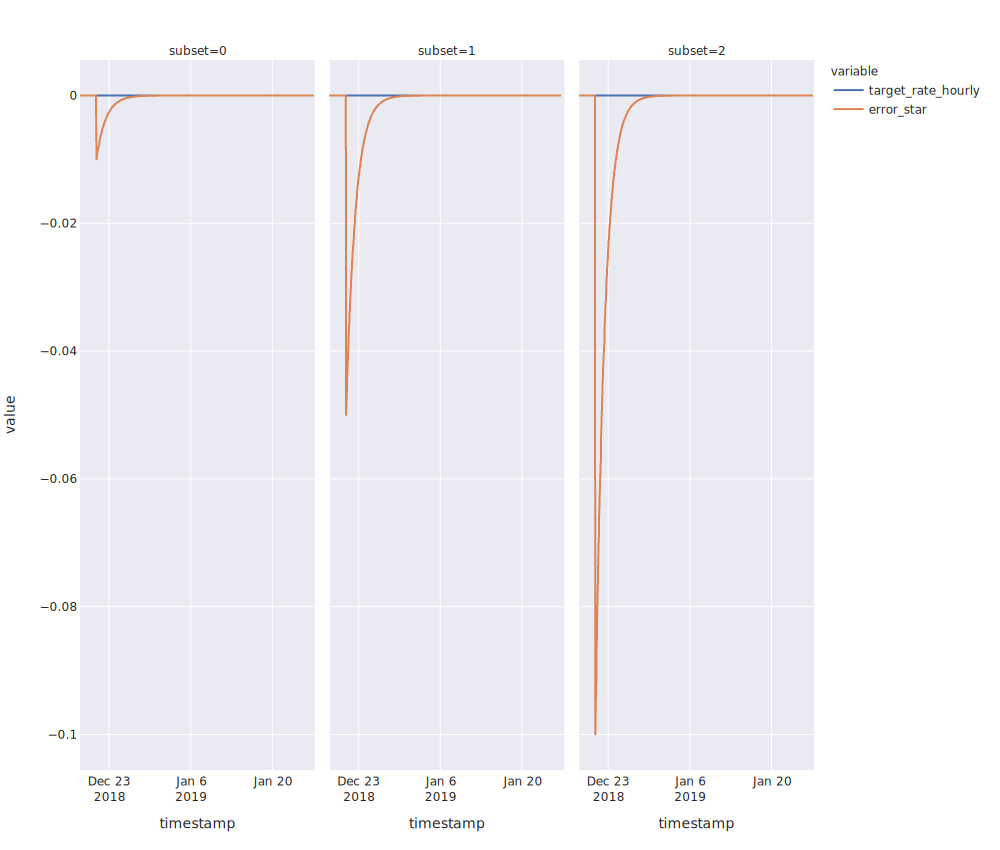

In [14]:
fig = px.line(
    df,
    x='timestamp',
    y=['target_rate_hourly', 'error_star'],
    facet_col='subset',
    facet_col_wrap=3,
    template='seaborn',
    height=800
)

# fig.show()
fig.write_image('plots/notebook_validation_market_price/target_rate.svg', width=1000, height=850)
from IPython.display import SVG,display
display(SVG(filename='plots/notebook_validation_market_price/target_rate.svg'))

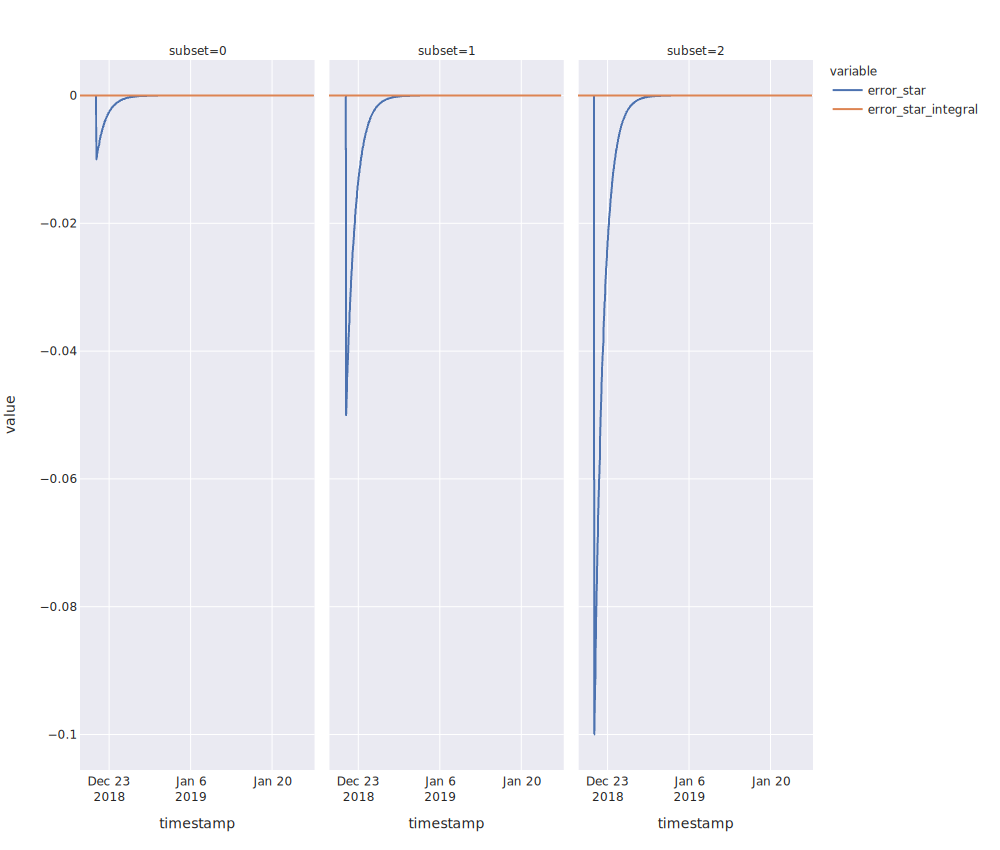

In [15]:
fig = px.line(
    df,
    x='timestamp',
    y=['error_star', 'error_star_integral'],
    facet_col='subset',
    facet_col_wrap=3,
    template='seaborn',
    height=800
)

# fig.show()
fig.write_image('plots/notebook_validation_market_price/error_star.svg', width=1000, height=850)
from IPython.display import SVG,display
display(SVG(filename='plots/notebook_validation_market_price/error_star.svg'))

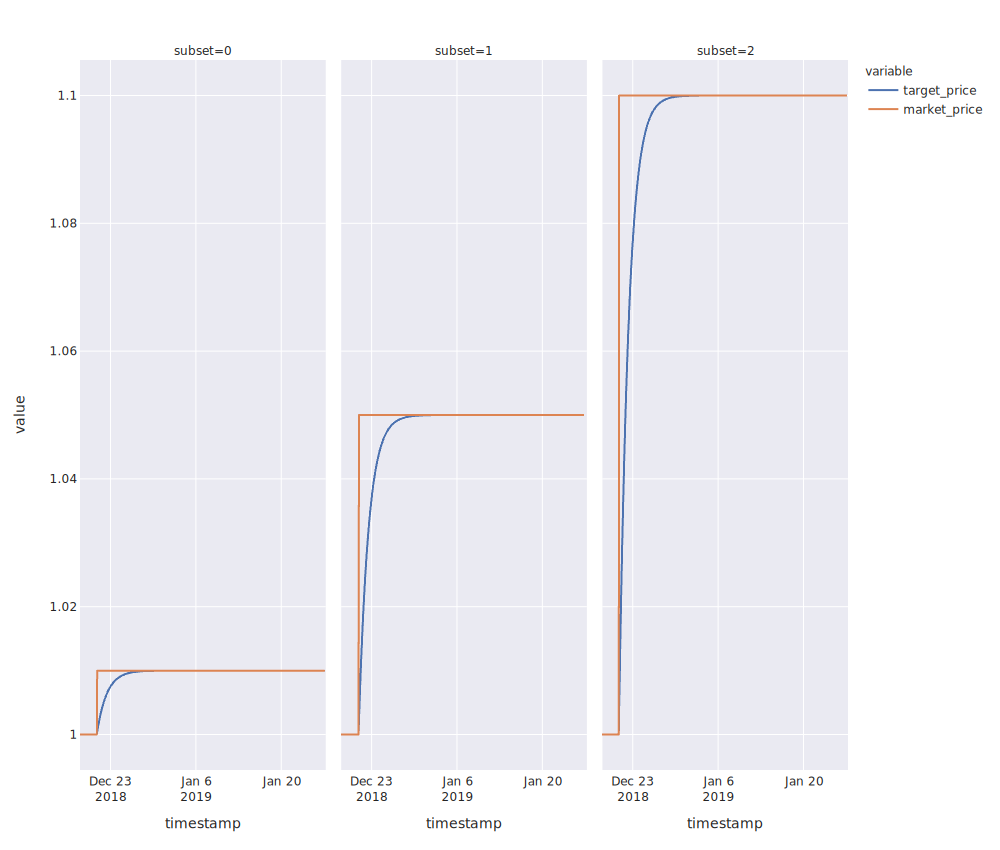

In [21]:
fig = px.line(
    df,
    x='timestamp',
    y=['target_price', 'market_price'],
    facet_col_wrap=3,
    facet_col='subset',
    template='seaborn',
    height=800
)

# fig.show()
fig.write_image('plots/notebook_validation_market_price/response.svg', width=1000, height=850)
from IPython.display import SVG,display
display(SVG(filename='plots/notebook_validation_market_price/response.svg'))

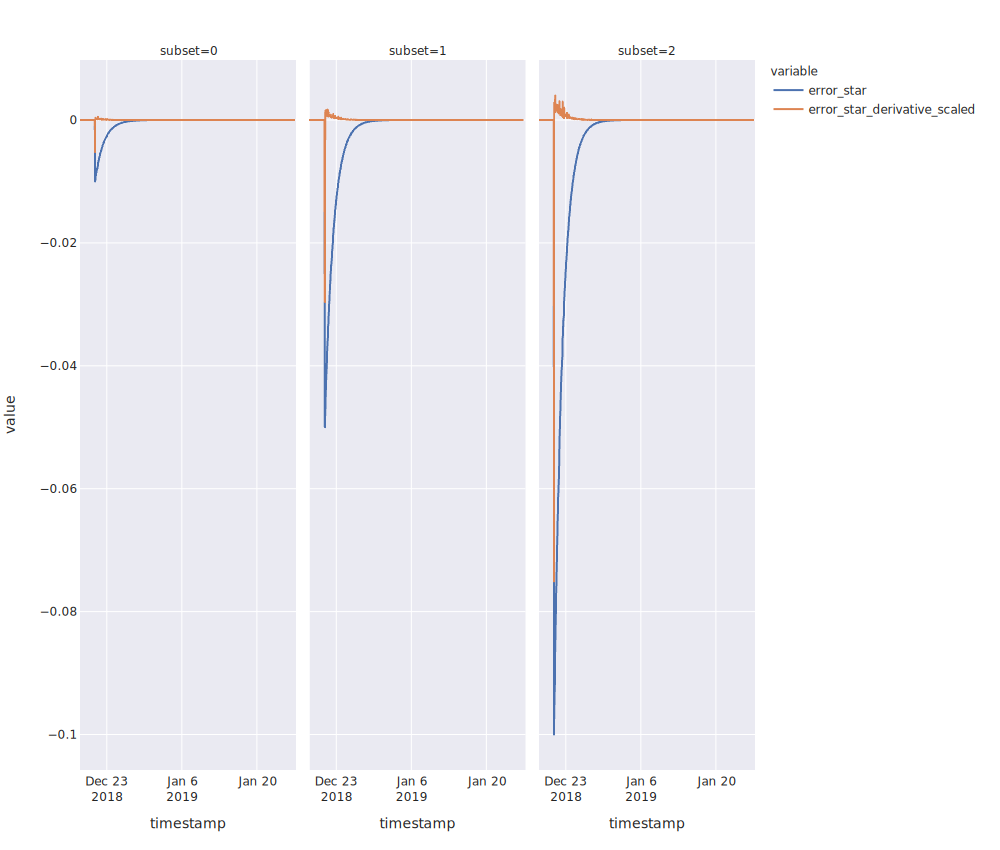

In [20]:
fig = px.line(
    df,
    x='timestamp',
    y=['error_star','error_star_derivative_scaled'],
    facet_col='subset',
    facet_col_wrap=3,
    template='seaborn',
    height=800
)

# fig.show()
fig.write_image('plots/notebook_validation_market_price/error_star_derivative.svg', width=1000, height=850)
from IPython.display import SVG,display
display(SVG(filename='plots/notebook_validation_market_price/error_star_derivative.svg'))

## Controller Metrics

In [18]:
pv_initial = df['market_price'][0]
pv_max = df['market_price'][df.index[-1]]

target_initial = df[df.target_price > pv_initial].iloc[0]

time_constant = df[df.target_price - pv_initial >= 0.63 * (pv_max - pv_initial)].iloc[0].timestamp - target_initial.timestamp

f'Controller time constant: {time_constant}'

'Controller time constant: 1 days 13:04:43'